In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import time

#Cosas útiles para utilizar luego
from sympy import oo
from __future__ import division #??

#Estética

sp.init_printing() #??
%matplotlib inline 
#Magic commands (Jupyter)

#plt.rcParams['figure.figsize']

#Definimos los simbolos que vamos a usar

r=sp.Symbol('r',positive=True)
l=sp.Symbol('l',positive=True,integer=True)
n=sp.Symbol('n',positive=True,integer=True)
z=sp.Symbol('z',positive=True,integer=True)
k=sp.Symbol('k',positive=True)

In [3]:
#Función radial hidrogénica (con hipergeométricas)
#Esta es la R grande, R=u/r

def R_hyp(n,l,z,r):
    rho = 2*r*z/n
    rnum = (2*z/n)**3 * sp.factorial(n+l)
    rden = (sp.factorial(2*l+1))**2 * 2*n * sp.factorial(n-l-1)
    rnorm = sp.sqrt(rnum/rden)
    
    #if -n+l+1 == 0:
    #    rfunc = (rho)**l * sp.exp(-rho/2)
    #else:
    rfunc = (rho)**l * sp.exp(-rho/2) * sp.hyper((-n+l+1,),(2*l+2,),(rho))
        
    R = rnorm * rfunc
    return R

## Chequeo si cumple Schrödinger

In [4]:
#Defino el operador Laplaciano (el termino radial)

n=1
l=0
#z=5

sp.expand(sp.simplify( (-1/2)*sp.diff( r*R_hyp(n,l,z,r) , r, 2 ) + r*R_hyp(n,l,z,r)*((-z/r) + l*(l+1)/r**2) - (-z**2/(2*n**2))*r*R_hyp(n,l,z,r) ))

#E=sp.cancel( ((-1/2)*sp.diff( r**2 * sp.diff( R_hyp(1,0,z,r) , r ) , r )/(r**2) - R_hyp(1,0,z,r)*z/r)/R_hyp(1,0,z,r) )
#El sp.cancel es para simplificar la expresion
#print('Energia = ', E)

In [5]:
#Definición de los vectores para plotear

nsize=500
xmax=8.0
xmin=0.
x=np.linspace(xmin,xmax,nsize)
psi_a=np.zeros(nsize)
psi_b=np.zeros(nsize)

## Elijo el Fluor (F): Z = 9

## Elijo dos términos del ión hidrogénico
### a) n = 1, l = 0 (s)
### b) n = 3, l = 2 (d)

In [6]:
#Copiamos el array simbólico a numérico
#%time 
for i in range(nsize):
    psi_a[i]=R_hyp(1,0,9,x[i])
    psi_b[i]=R_hyp(3,2,9,x[i])

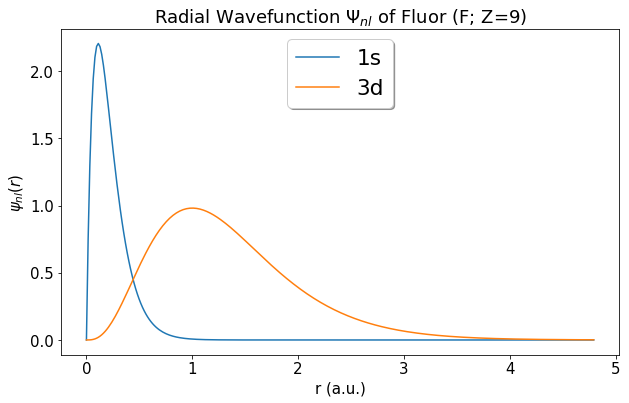

In [7]:
#Ploteo
plt.figure(figsize=(10,6))

plt.rcParams.update({'font.size': 15})

plt.plot(x[0:300],x[0:300]*psi_a[0:300],label='1s');
plt.plot(x[0:300],x[0:300]*psi_b[0:300],label='3d');

legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
#legend.get_frame().set_facecolor('#00FFCC') #Le pone un fondo a la leyenda

plt.title("Radial Wavefunction $\Psi_{nl}$ of Fluor (F; Z=9)");
plt.xlabel("r (a.u.)");
plt.ylabel("$\psi_{nl}(r)$");

## Comportamiento asintótico

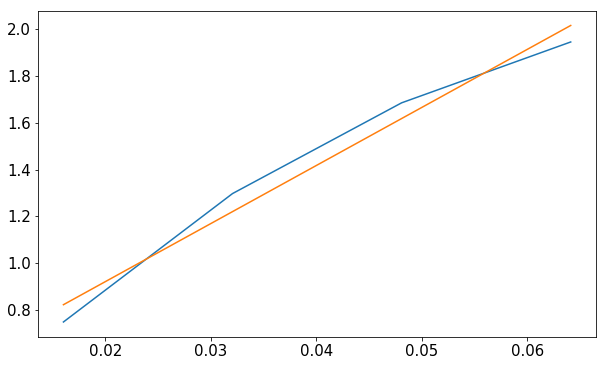

In [8]:
#Para r tendiendo a cero
nlim=5
a,b=np.polyfit(x[1:nlim], x[1:nlim]*psi_a[1:nlim], 1)

plt.figure(figsize=(10,6))
plt.plot(x[1:nlim], x[1:nlim]*psi_a[1:nlim]);
plt.plot(x[1:nlim], a*x[1:nlim] + b);

# Integrales, valores medios: $\int_0^{\infty}\Psi r^k \Psi dr$

In [9]:
start_time = time.time();
integral = sp.integrate( (r * R_hyp(2,1,9,r)) * r**-1 * (r * R_hyp(2,1,9,r)), (r,0,oo) ).evalf();
elapsed_time = time.time() - start_time;

print("Evaluated integral = ", integral)
print("Time elapsed = ", round(elapsed_time,2), "seconds")
print("Exact value for 1/r = ", 9./2.**2)

Evaluated integral =  2.25000000000000
Time elapsed =  2.9 seconds
Exact value for 1/r =  2.25


### Condición de Kato: $ \cfrac{\cfrac{\partial}{\partial r}\psi_{ns}(r)_{r=0}}{\psi_{ns}(r=0)}=-Z  $

In [18]:
#Lo hago simbolico, para el 1s

f=sp.diff( R_hyp(1,0,z,r) , r )/R_hyp(1,0,z,r)
print(sp.cancel( f.evalf(subs={r:0}) ))

f=R_hyp(1,0,1,r)
print(f)
print(sp.cancel( f.evalf(subs={r:0}) ))

-z
2.0*exp(-r)*hyper((0,), (2,), 2*r)
2.00000000000000


### Oppenheimer: $ (\psi_{ns}(r=0))^2= \cfrac{Z^3}{\pi n^3}$

In [11]:
(np.pi*(R_hyp(2,0,z,0).evalf())**2 /(4*np.pi))

### Teorema del Virial: $ \cfrac{\langle V\rangle}{\langle T\rangle}=-2 $

In [12]:
meanpotential = sp.integrate( (r * R_hyp(1,0,1,r)) * (-1*(1/r)) * (r * R_hyp(1,0,1,r)), (r,0,oo) ).evalf()

kinet=(-1/2)*sp.diff( r**2 * sp.diff( R_hyp(1,0,1,r) , r ) , r )/(r**2)
#kinet.subs(r,3).evalfkinet=sp.cancel(kinet)

meankinetic = sp.integrate( r**2 * (R_hyp(1,0,1,r))*kinet , (r,0,oo) ).evalf()

print('V/T = ', meanpotential/meankinetic)

V/T =  -2.00000000000000


### Transformada Fourier, Schrödinger en espacio de momentos

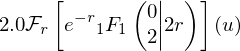

In [13]:
func_k=sp.integrate( r**2 * R_hyp(1,0,1,r)*sp.exp(-1j*k*r) , (r,0,10) ).evalf()/(2*np.pi)**(3/2)
#func_k.expand

u=sp.Symbol('u',positive=True)
#func_u=sp.expand( sp.integrate( r**2 * R_hyp(1,0,1,r)*sp.exp(-1j*u*r) , (r,0,oo) ).evalf()/(2*np.pi)**(3/2) )
func_u=sp.fourier_transform(R_hyp(1,0,1,r),r,u,simplify=True)
func_u

#Schrödinger en espacio de momentos
#result = sp.cancel( sp.integrate( ( -np.sqrt(2/np.pi)*1/((k+u)**2) )*func_u * u**2 , (u,0,10)).evalf()/func_k ) + (k**2)/2 
#result = sp.integrate(func_u,(u,0,2)).evalf()
#result